In [1]:
import os
import pandas as pd
import numpy as np
from Historic_Crypto import HistoricalData
import talib
import ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.dates as mdates

2022-04-25 03:02:38.367975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/openmpi/lib:/usr/local/lib:/usr/lib:/usr/local/openmpi/lib:/usr/local/lib:/usr/lib:
2022-04-25 03:02:38.368006: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load the data and save it

In [3]:
btc_current_price = HistoricalData('BTC-USDT',3600,'2021-12-20-00-00', '2022-04-01-00-00', verbose=False).retrieve_data()
btc_current_price.to_csv('../data/BTC-USD-1h-latest.csv')

Provisional Start: 2021-12-20T00:00:00
Provisional End: 2022-01-01T12:00:00
Provisional Start: 2022-01-01T12:00:00
Provisional End: 2022-01-14T00:00:00
Provisional Start: 2022-01-14T00:00:00
Provisional End: 2022-01-26T12:00:00
Provisional Start: 2022-01-26T12:00:00
Provisional End: 2022-02-08T00:00:00
Provisional Start: 2022-02-08T00:00:00
Provisional End: 2022-02-20T12:00:00
Provisional Start: 2022-02-20T12:00:00
Provisional End: 2022-03-05T00:00:00
Provisional Start: 2022-03-05T00:00:00
Provisional End: 2022-03-17T12:00:00
Provisional Start: 2022-03-17T12:00:00
Provisional End: 2022-03-30T00:00:00
Provisional Start: 2022-03-30T00:00:00
Provisional End: 2022-04-11T12:00:00


## Next Hour Prediction

2022-04-25 03:06:23.399568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/openmpi/lib:/usr/local/lib:/usr/lib:/usr/local/openmpi/lib:/usr/local/lib:/usr/lib:
2022-04-25 03:06:23.399600: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 03:06:23.399617: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-42-211): /proc/driver/nvidia/version does not exist
2022-04-25 03:06:23.399813: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate c

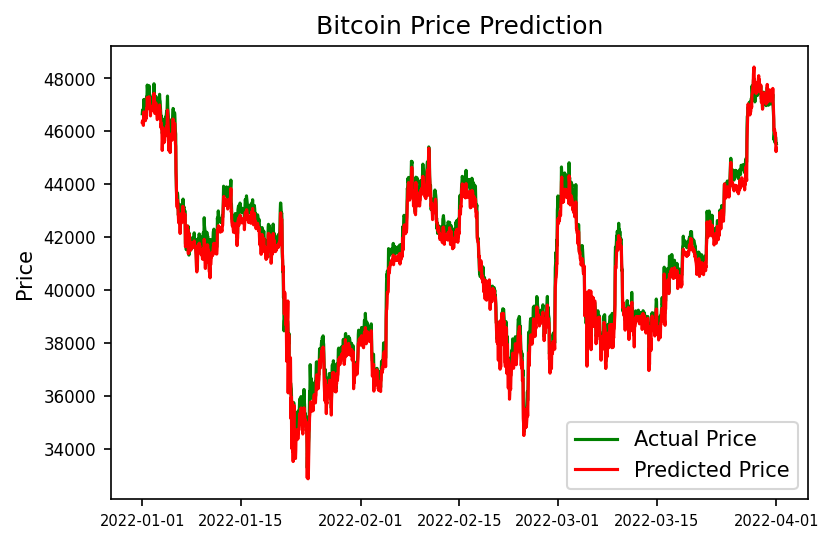

In [4]:
## read the data and prepare the TA indicators
df = pd.read_csv('../data/BTC-USD-1h-latest.csv', parse_dates=['time'])
df = df.rename(columns={'time':'Date', 'low':'Low', 'high':'High', 'open':'Open', 'close':'Close', 'volume':'Volume'})
df['EMA7'] = talib.EMA(df['Close'], timeperiod=7)
df['EMA30'] = talib.EMA(df['Close'], timeperiod=30)
df['EMA90'] = talib.EMA(df['Close'], timeperiod=90)
df['MACD'], MACDSIGNAL, MACDHIST = talib.MACD(df['Close'])
df['MFI'] = talib.MFI(df['High'], df['Low'], df['Close'], df['Volume'])
df['RSI'] = talib.RSI(df['Close'])
df['VWAP'] = ta.volume.VolumeWeightedAveragePrice(df['High'], df['Low'], df['Close'], df['Volume']).volume_weighted_average_price()
df['DEMA'] = talib.DEMA(df['Close'])

## convert the data into sequences 
SEQ_LEN=100
df_model = df.copy().drop('Date', axis=1).iloc[89:]
features = df_model.columns
scaler_pred = MinMaxScaler()
df_close = pd.DataFrame(df_model['Close'])
df_close = scaler_pred.fit_transform(df_close)
scaler = MinMaxScaler()
df_model = scaler.fit_transform(df_model)

def preprocess(data, index_Close, sequence_length):
    
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len+1):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        if i != data_len:
            y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    return x, y

X, y = preprocess(df_model, index_Close=df.columns.get_loc('Close')-1, sequence_length=SEQ_LEN)


## load the pre-trained LSTM model
model = load_model('../model/kbot_model_LSTM_1.h5')

## apply the model to predict the price of next hour
y_pred = model.predict(X)

y_pred = scaler_pred.inverse_transform(y_pred.reshape(-1, 1))
y_pred = y_pred[:,0]

df_result = df.tail(2161)[['Date', 'Low', 'High', 'Open', 'Volume', 'Close']].reset_index(drop=True)
df_result['Predict'] = pd.Series(y_pred[-2161:])


## plot the graph of the predicted price and compare it with the actual price
plt.plot(df_result['Date'], df_result['Close'], label="Actual Price", color='green')
plt.plot(df_result['Date'], df_result['Predict'], label="Predicted Price", color='red')

plt.title('Bitcoin Price Prediction')
plt.ylabel('Price')
plt.legend(loc='best')
plt.xticks(fontsize=7,)
plt.yticks(fontsize=8,)
 
plt.show();

In [5]:
df_analysis = df_result.copy()

## The Hour After Next Hour Prediction

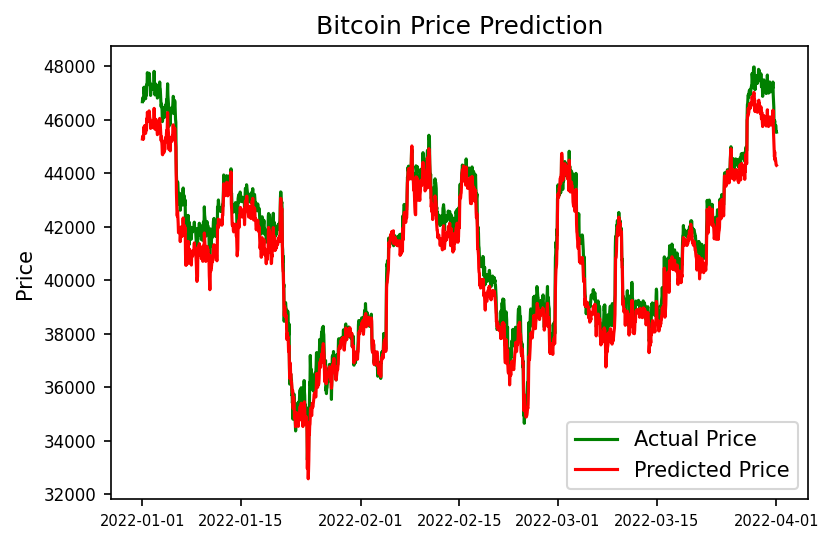

In [6]:
## convert the data into sequences 
SEQ_LEN=100
df_model2 = df.copy().drop('Date', axis=1).iloc[89:]
features2 = df_model2.columns
scaler_pred2 = MinMaxScaler()
df_close2 = pd.DataFrame(df_model2['Close'])
df_close2 = scaler_pred2.fit_transform(df_close2)
scaler2 = MinMaxScaler()
df_model2 = scaler.fit_transform(df_model2)

def preprocess2(data, index_Close, sequence_length):
    
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len+1):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        if i < data_len-1:
            y.append(data[i+1, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    return x, y

X2, y2 = preprocess(df_model2, index_Close=df.columns.get_loc('Close')-1, sequence_length=SEQ_LEN)


## load the pre-trained LSTM model
model2 = load_model('../model/kbot_model_LSTM_2.h5')


## apply the model to predict the price of the hour after next hour
y_pred2 = model2.predict(X2)

y_pred2 = scaler_pred2.inverse_transform(y_pred2.reshape(-1, 1))
y_pred2 = y_pred2[:,0]

df_result2 = df.tail(2161)[['Date', 'Low', 'High', 'Open', 'Volume', 'Close']].reset_index(drop=True)
df_result2['Predict'] = pd.Series(y_pred2[-2161:])


## plot the graph of the predicted price and compare it with the actual price
plt.plot(df_result2['Date'], df_result2['Close'], label="Actual Price", color='green')
plt.plot(df_result2['Date'], df_result2['Predict'], label="Predicted Price", color='red')

plt.title('Bitcoin Price Prediction')
plt.ylabel('Price')
plt.legend(loc='best')
plt.xticks(fontsize=7,)
plt.yticks(fontsize=8,)
 
plt.show();

In [7]:
df_analysis2 = df_result2.copy()

In [10]:
df_analysis['Predict2'] = df_analysis2['Predict']
df_backtrader = df_analysis[1:][['Date', 'Low', 'High', 'Open', 'Volume', 'Close']]
df_backtrader['DLI1'] = df_analysis[1:]['Predict']
df_backtrader['DLI2'] = df_analysis[1:]['Predict2']
df_backtrader.to_csv('../data/BTC-USD-backtrader.csv', index=False)

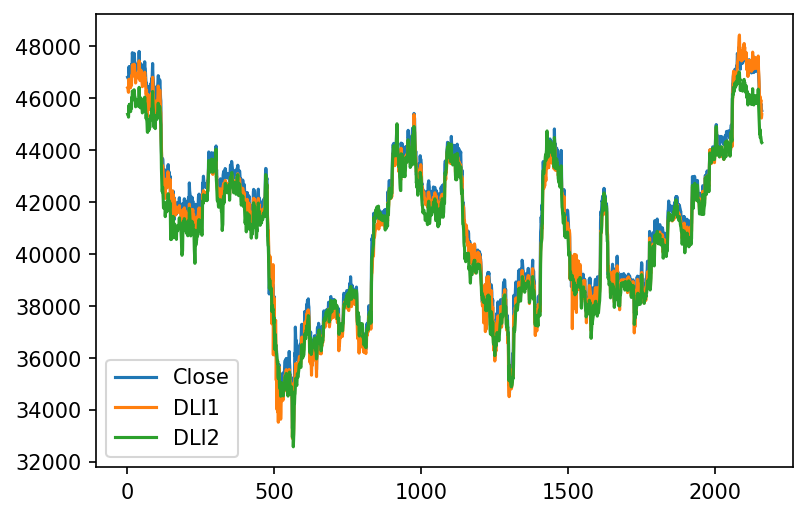

In [11]:
df_backtrader['Close'].plot()
df_backtrader['DLI1'].plot()
df_backtrader['DLI2'].plot()
plt.legend(loc='best')